In [1]:
%cd D:\MastersFolder\2nd_year\Image_Processing_And_Analysis\Project
    

D:\MastersFolder\2nd_year\Image_Processing_And_Analysis\Project


In [2]:
import numpy as np
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import tensorflow as tf
tf.compat.v1.set_random_seed(2019)

In [3]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16,(3,3),activation = "relu" , input_shape = (180,180,3)) ,
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32,(3,3),activation = "relu") ,  
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64,(3,3),activation = "relu") ,  
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128,(3,3),activation = "relu"),  
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(550,activation="relu"),      #Adding the Hidden layer
    tf.keras.layers.Dropout(0.1,seed = 2019),
    tf.keras.layers.Dense(400,activation ="relu"),
    tf.keras.layers.Dropout(0.3,seed = 2019),
    tf.keras.layers.Dense(300,activation="relu"),
    tf.keras.layers.Dropout(0.4,seed = 2019),
    tf.keras.layers.Dense(200,activation ="relu"),
    tf.keras.layers.Dropout(0.2,seed = 2019),
    tf.keras.layers.Dense(2,activation = "softmax")   #Adding the Output Layer
])

In [4]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 178, 178, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 89, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 87, 87, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 43, 43, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 41, 41, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 20, 20, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 18, 18, 128)       7

In [6]:
from tensorflow.keras import backend as K
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [20]:
from tensorflow.keras.optimizers import RMSprop,SGD,Adam
adam=Adam(lr=0.001)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['accuracy','Precision','Recall'])

In [14]:
import os
base_dir = 'Database/Classification/Non_segmentation_classification/ISIC2018/'
train_dir = os.path.join(base_dir, 'Train')
validation_dir = os.path.join(base_dir, 'Validation')

# Directory with our training cat pictures
train_melanoma_dir = os.path.join(train_dir, 'Melanoma')

# Directory with our training dog pictures
train_non_melanoma_dir = os.path.join(train_dir, 'Non_melanoma')

# Directory with our validation cat pictures
validation_melanoma_dir = os.path.join(validation_dir, 'Melanoma')

# Directory with our validation dog pictures
validation_non_melanoma_dir = os.path.join(validation_dir, '/Non_melanoma')

In [12]:
train_cat_fnames = os.listdir( train_melanoma_dir )

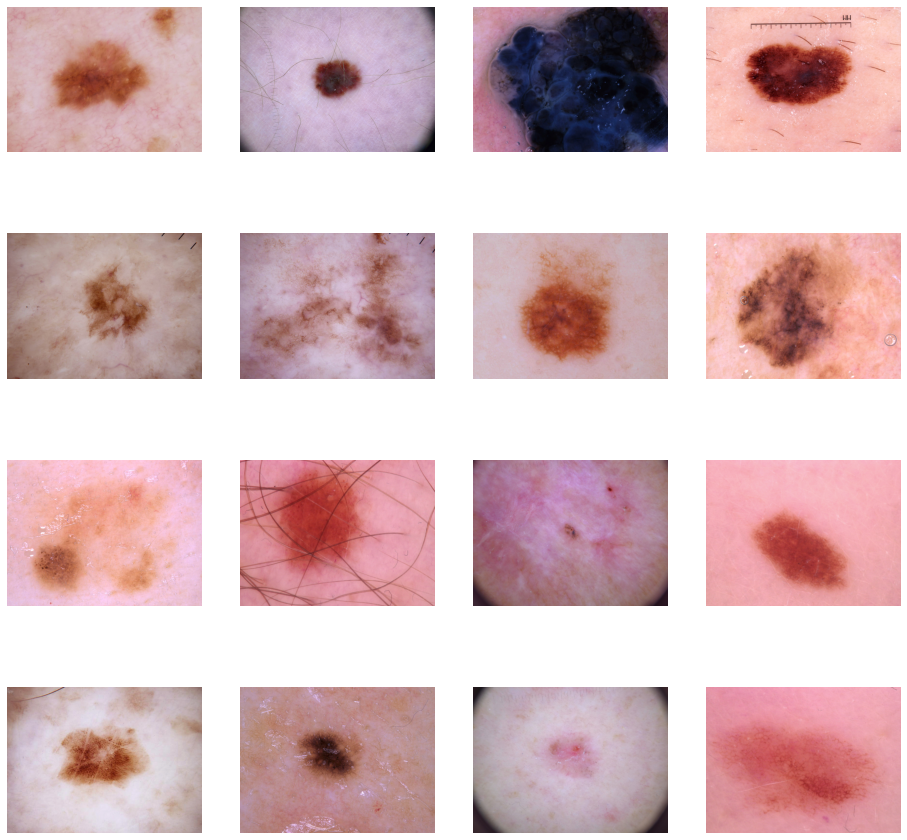

In [15]:
# Set up matplotlib fig, and size it to fit 4x4 pics
import matplotlib.image as mpimg
nrows = 4
ncols = 4

fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)
pic_index = 100
train_melanoma_fnames = os.listdir( train_melanoma_dir )
train_non_melanoma_fnames = os.listdir( train_non_melanoma_dir )


next_melanoma_pix = [os.path.join(train_melanoma_dir, fname) 
                for fname in train_melanoma_fnames[ pic_index-8:pic_index] 
               ]

next_non_melanoma_pix = [os.path.join(train_non_melanoma_dir, fname) 
                for fname in train_non_melanoma_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_melanoma_pix+next_non_melanoma_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

In [17]:
bs=10
# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir, batch_size = bs, class_mode = 'categorical', target_size = (180, 180))

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory( validation_dir,  batch_size = bs, class_mode = 'categorical', target_size = (180, 180))

Found 1400 images belonging to 2 classes.
Found 193 images belonging to 2 classes.


In [18]:
import tensorflow as tf
from tensorflow.compat.v1.keras.backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.compat.v1.Session(config=config)
set_session(sess)


Device mapping: no known devices.


In [21]:
history = model.fit(train_generator,
                    validation_data=validation_generator,
                    steps_per_epoch=150 // bs,
                    epochs=10,
                    validation_steps=50 // bs,
                    verbose=2)

Epoch 1/10
15/15 - 5s - loss: 0.6929 - accuracy: 0.4533 - precision: 0.4533 - recall: 0.4533 - val_loss: 0.6910 - val_accuracy: 0.3200 - val_precision: 0.3200 - val_recall: 0.3200
Epoch 2/10
15/15 - 4s - loss: 0.6966 - accuracy: 0.4667 - precision: 0.4667 - recall: 0.4667 - val_loss: 0.7136 - val_accuracy: 0.1200 - val_precision: 0.1200 - val_recall: 0.1200
Epoch 3/10
15/15 - 4s - loss: 0.6940 - accuracy: 0.5067 - precision: 0.5067 - recall: 0.5067 - val_loss: 0.6969 - val_accuracy: 0.1200 - val_precision: 0.1200 - val_recall: 0.1200
Epoch 4/10
15/15 - 4s - loss: 0.7009 - accuracy: 0.5467 - precision: 0.5467 - recall: 0.5467 - val_loss: 0.6182 - val_accuracy: 0.9000 - val_precision: 0.9000 - val_recall: 0.9000
Epoch 5/10
15/15 - 4s - loss: 0.6934 - accuracy: 0.5000 - precision: 0.5000 - recall: 0.5000 - val_loss: 0.7143 - val_accuracy: 0.1200 - val_precision: 0.1200 - val_recall: 0.1200
Epoch 6/10
15/15 - 4s - loss: 0.6959 - accuracy: 0.4467 - precision: 0.4467 - recall: 0.4467 - val_l

In [25]:
train_f1=[]
val_f1 = []
NUM_EPOCHS = 10
for i in range(NUM_EPOCHS):
    
    train_f1.append(2* (history.history['precision'][i]*history.history['recall'][i])/(history.history['precision'][i]+history.history['recall'][i]))
    
for i in range(NUM_EPOCHS):
    val_f1.append(2* (history.history['val_precision'][i]*history.history['val_recall'][i])/(history.history['val_precision'][i]+history.history['val_recall'][i]))

In [26]:
print("Train Accuracy = ",history.history['accuracy'][NUM_EPOCHS-1])
print("Train Loss = ",history.history['loss'][NUM_EPOCHS-1])

print("Validation Accuracy = ",history.history['val_accuracy'][NUM_EPOCHS-1])
print("Validation Loss = ",history.history['val_loss'][NUM_EPOCHS-1])


print("Train Recall =",history.history['recall'][NUM_EPOCHS-1])

print("Validation Recall = ",history.history['val_recall'][NUM_EPOCHS-1])


print("Train F1Score =",train_f1[NUM_EPOCHS-2])

print("Validation F1Score =",val_f1[NUM_EPOCHS-2])


Train Accuracy =  0.4933333396911621
Train Loss =  0.6927683353424072
Validation Accuracy =  0.8799999952316284
Validation Loss =  0.6816495656967163
Train Recall = 0.4933333396911621
Validation Recall =  0.8799999952316284
Train F1Score = 0.5333333611488342
Validation F1Score = 0.3400000035762787


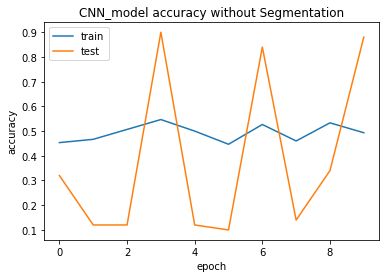

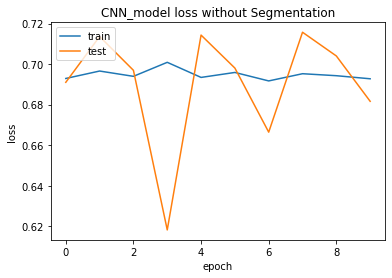

In [28]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('CNN_model accuracy without Segmentation')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('CNN_model loss without Segmentation')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# RestNet50

In [29]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Add
from tensorflow.keras.layers import GlobalAveragePooling2D, Flatten, Dense

In [30]:
def residual_block(X_start, filters, name, reduce=False, res_conv2d=False):
    """
    Residual building block used by ResNet-50
    """
    nb_filters_1, nb_filters_2, nb_filters_3 = filters
    strides_1 = [2,2] if reduce else [1,1]
        
    X = Conv2D(filters=nb_filters_1, kernel_size=[1,1], strides=strides_1, padding='same', name=name)(X_start)
    X = BatchNormalization()(X)      # default axis-1 is ok
    X = Activation('relu')(X)
    
    X = Conv2D(filters=nb_filters_2, kernel_size=[3,3], strides=[1,1], padding='same')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    
    X = Conv2D(filters=nb_filters_3, kernel_size=[1,1], strides=[1,1], padding='same')(X)
    X = BatchNormalization()(X)
    
    if res_conv2d:
        X_res = Conv2D(filters=nb_filters_3, kernel_size=[1,1], strides=strides_1, padding='same')(X_start)
        X_res = BatchNormalization()(X_res)
    else:
        X_res = X_start
        
    X = Add()([X, X_res])
    X = Activation('relu')(X)
    return X

In [31]:
def resnet50(input_shape, nb_classes):
    assert len(input_shape) == 3
    
    X_input = Input(shape=input_shape)

    # conv1
    X = Conv2D(filters=64, kernel_size=[7,7], strides=[2,2], padding='same', name='conv1')(X_input)
    X = BatchNormalization(name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D([3,3], strides=[2,2])(X)

    # conv2_x
    X = residual_block(X, filters=[64, 64, 256], name='conv2_a', reduce=False, res_conv2d=True)
    X = residual_block(X, filters=[64, 64, 256], name='conv2_b')
    X = residual_block(X, filters=[64, 64, 256], name='conv2_c')

    # conv3_x
    X = residual_block(X, filters=[128, 128, 512], name='conv3_a', reduce=True, res_conv2d=True)
    X = residual_block(X, filters=[128, 128, 512], name='conv3_b')
    X = residual_block(X, filters=[128, 128, 512], name='conv3_c')
    X = residual_block(X, filters=[128, 128, 512], name='conv3_d')

    # conv4_x
    X = residual_block(X, filters=[256, 256, 1024], name='conv4_a', reduce=True, res_conv2d=True)
    X = residual_block(X, filters=[256, 256, 1024], name='conv4_b')
    X = residual_block(X, filters=[256, 256, 1024], name='conv4_c')
    X = residual_block(X, filters=[256, 256, 1024], name='conv4_d')
    X = residual_block(X, filters=[256, 256, 1024], name='conv4_e')
    X = residual_block(X, filters=[256, 256, 1024], name='conv4_f')

    # conv5_x
    X = residual_block(X, filters=[512, 512, 2048], name='conv5_a', reduce=True, res_conv2d=True)
    X = residual_block(X, filters=[512, 512, 2048], name='conv5_b')
    X = residual_block(X, filters=[512, 512, 2048], name='conv5_c')

    X = GlobalAveragePooling2D(name='avg_pool')(X)
    X = Flatten()(X)
    X = Dense(units=nb_classes, activation='softmax')(X)
    
    model = tf.keras.models.Model(inputs=X_input, outputs=X)
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001),
                  loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [32]:
model = resnet50(input_shape=[224, 224, 3], nb_classes=2)

In [33]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation (Activation)         (None, 112, 112, 64) 0           bn_conv1[0][0]                   
_______________________________________________________________________________________

In [34]:
from tensorflow.keras.optimizers import RMSprop,SGD,Adam
adam=Adam(lr=0.001)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['accuracy','Precision','Recall'])

In [35]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
# Add our data-augmentation parameters to ImageDataGenerator
rest_train_datagen = ImageDataGenerator(rescale = 1./255.,rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)

# Note that the validation data should not be augmented!
rest_test_datagen = ImageDataGenerator( rescale = 1.0/255. )

bs=10
# Flow training images in batches of 20 using train_datagen generator
rest_train_generator = rest_train_datagen.flow_from_directory(train_dir, batch_size = bs, class_mode = 'categorical', target_size = (224, 224))

# Flow validation images in batches of 20 using test_datagen generator
rest_validation_generator = rest_test_datagen.flow_from_directory(validation_dir,  batch_size = bs, class_mode = 'categorical', target_size = (224, 224))


Found 1400 images belonging to 2 classes.
Found 193 images belonging to 2 classes.


In [36]:
# Fixed for our Cats & Dogs classes
NUM_CLASSES = 2

# Fixed for Cats & Dogs color images
CHANNELS = 3

IMAGE_RESIZE = 224
RESNET50_POOLING_AVERAGE = 'avg'
DENSE_LAYER_ACTIVATION = 'softmax'
OBJECTIVE_FUNCTION = 'categorical_crossentropy'

# Common accuracy metric for all outputs, but can use different metrics for different output
LOSS_METRICS = ['accuracy']

# EARLY_STOP_PATIENCE must be < NUM_EPOCHS
NUM_EPOCHS = 10
EARLY_STOP_PATIENCE = 3

# These steps value should be proper FACTOR of no.-of-images in train & valid folders respectively
# Training images processed in each step would be no.-of-train-images / STEPS_PER_EPOCH_TRAINING
STEPS_PER_EPOCH_TRAINING = 10
STEPS_PER_EPOCH_VALIDATION = 10

# These steps value should be proper FACTOR of no.-of-images in train & valid folders respectively
# NOTE that these BATCH* are for Keras ImageDataGenerator batching to fill epoch step input
BATCH_SIZE_TRAINING = 16
BATCH_SIZE_VALIDATION = 16

# Using 1 to easily manage mapping between test_generator & prediction for submission preparation
BATCH_SIZE_TESTING = 1

In [98]:
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_size = IMAGE_RESIZE

# preprocessing_function is applied on each image but only after re-sizing & augmentation (resize => augment => pre-process)
# Each of the keras.application.resnet* preprocess_input MOSTLY mean BATCH NORMALIZATION (applied on each batch) stabilize the inputs to nonlinear activation functions
# Batch Normalization helps in faster convergence
data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

# flow_From_directory generates batches of augmented data (where augmentation can be color conversion, etc)
# Both train & valid folders must have NUM_CLASSES sub-folders
train_generator = data_generator.flow_from_directory(train_dir,     
        target_size=(image_size, image_size),
        batch_size=BATCH_SIZE_TRAINING,
        class_mode='categorical')

validation_generator = data_generator.flow_from_directory(validation_dir,
        target_size=(image_size, image_size),
        batch_size=BATCH_SIZE_VALIDATION,
        class_mode='categorical') 

Found 1400 images belonging to 2 classes.
Found 193 images belonging to 2 classes.


In [37]:
(BATCH_SIZE_TRAINING, len(train_generator), BATCH_SIZE_VALIDATION, len(validation_generator))

(16, 140, 16, 20)

In [38]:
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint

cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = EARLY_STOP_PATIENCE)
cb_checkpointer = ModelCheckpoint(filepath = 'RestNet50.hdf5', monitor = 'val_loss', save_best_only = True, mode = 'auto')

In [39]:
fit_history = model.fit_generator(
        train_generator,
        steps_per_epoch=STEPS_PER_EPOCH_TRAINING,
        epochs = NUM_EPOCHS,
        validation_data=validation_generator,
        validation_steps=STEPS_PER_EPOCH_VALIDATION,
        callbacks=[cb_checkpointer, cb_early_stopper]
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
10/10 [==============================] - 19s 2s/step - loss: 2.0099 - accuracy: 0.5900 - precision: 0.5900 - recall: 0.5900 - val_loss: 0.7133 - val_accuracy: 0.2600 - val_precision: 0.2600 - val_recall: 0.2600
Epoch 2/10
10/10 [==============================] - 18s 2s/step - loss: 1.6468 - accuracy: 0.4400 - precision: 0.4400 - recall: 0.4400 - val_loss: 0.3866 - val_accuracy: 0.8800 - val_precision: 0.8800 - val_recall: 0.8800
Epoch 3/10
10/10 [==============================] - 20s 2s/step - loss: 0.9963 - accuracy: 0.5700 - precision: 0.5700 - recall: 0.5700 - val_loss: 0.4182 - val_accuracy: 0.9200 - val_precision: 0.9200 - val_recall: 0.9200
Epoch 4/10
10/10 [==============================] - 19s 2s/step - loss: 0.5875 - accuracy: 0.7200 - precision: 0.7200 - recall: 0.7200 - val_loss: 0.4328 - val_accuracy: 0.8900 - val_precision: 0.8900 - val_recall: 0.8900
Epoch 5/10
10/10 [==================

In [41]:
train_f1=[]
val_f1 = []
NUM_EPOCHS = 5
for i in range(NUM_EPOCHS):
    
    train_f1.append(2* (fit_history.history['precision'][i]*fit_history.history['recall'][i])/(fit_history.history['precision'][i]+fit_history.history['recall'][i]))
    
for i in range(NUM_EPOCHS):
    val_f1.append(2* (fit_history.history['val_precision'][i]*fit_history.history['val_recall'][i])/(fit_history.history['val_precision'][i]+fit_history.history['val_recall'][i]))

In [44]:
print("Train Accuracy = ",fit_history.history['accuracy'][NUM_EPOCHS-1])
print("Train Loss = ",fit_history.history['loss'][NUM_EPOCHS-1])

print("Validation Accuracy = ",fit_history.history['val_accuracy'][NUM_EPOCHS-1])
print("Validation Loss = ",fit_history.history['val_loss'][NUM_EPOCHS-1])


print("Train Recall =",fit_history.history['recall'][NUM_EPOCHS-1])

print("Validation Recall = ",fit_history.history['val_recall'][NUM_EPOCHS-1])


print("Train F1Score =",train_f1[NUM_EPOCHS-2])

print("Validation F1Score =",val_f1[NUM_EPOCHS-2])


Train Accuracy =  0.7099999785423279
Train Loss =  0.7786595821380615
Validation Accuracy =  0.8799999952316284
Validation Loss =  0.5345610976219177
Train Recall = 0.7099999785423279
Validation Recall =  0.8799999952316284
Train F1Score = 0.7200000286102295
Validation F1Score = 0.8899999856948853


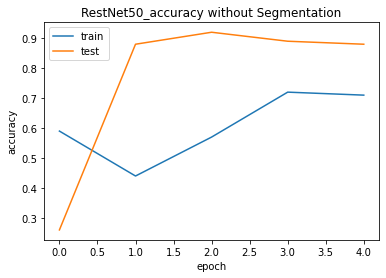

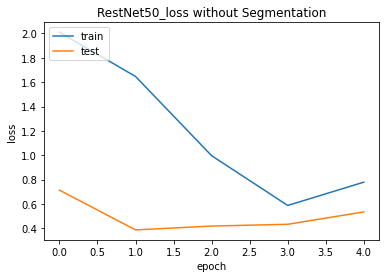

In [45]:
# summarize history for accuracy
plt.plot(fit_history.history['accuracy'])
plt.plot(fit_history.history['val_accuracy'])
plt.title('RestNet50_accuracy without Segmentation')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(fit_history.history['loss'])
plt.plot(fit_history.history['val_loss'])
plt.title('RestNet50_loss without Segmentation')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Transfer Learning Efficient Net

In [46]:
from tensorflow.keras.applications import EfficientNetB0
model = EfficientNetB0(weights='imagenet')

In [47]:
# IMG_SIZE is determined by EfficientNet model choice
IMG_SIZE = 224

In [49]:
from tensorflow.keras.applications import EfficientNetB0

strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    
    outputs = EfficientNetB0(include_top=True, weights=None, classes=NUM_CLASSES)(inputs)

    model = tf.keras.Model(inputs, outputs)
    model.compile(
        optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy','Precision','Recall']
    )

model.summary()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 2)                 4052133   
Total params: 4,052,133
Trainable params: 4,010,110
Non-trainable params: 42,023
_________________________________________________________________


In [50]:
cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = EARLY_STOP_PATIENCE)
cb_checkpointer = ModelCheckpoint(filepath = 'EfficientnetB0.hdf5', monitor = 'val_loss', save_best_only = True, mode = 'auto')

In [52]:
NUM_EPOCHS =10
fit_history = model.fit_generator(
        train_generator,
        steps_per_epoch=STEPS_PER_EPOCH_TRAINING,
        epochs = NUM_EPOCHS,
        validation_data=validation_generator,
        validation_steps=STEPS_PER_EPOCH_VALIDATION,
        callbacks=[cb_checkpointer, cb_early_stopper]
)

Epoch 1/10
10/10 [==============================] - 10s 981ms/step - loss: 3.3110 - accuracy: 0.5600 - precision: 0.5600 - recall: 0.5600 - val_loss: 0.6675 - val_accuracy: 0.9000 - val_precision: 0.9000 - val_recall: 0.9000
Epoch 2/10
10/10 [==============================] - 12s 1s/step - loss: 4.4175 - accuracy: 0.5000 - precision: 0.5000 - recall: 0.5000 - val_loss: 0.2974 - val_accuracy: 0.9200 - val_precision: 0.9200 - val_recall: 0.9200
Epoch 3/10
10/10 [==============================] - 12s 1s/step - loss: 2.6970 - accuracy: 0.5700 - precision: 0.5700 - recall: 0.5700 - val_loss: 0.2654 - val_accuracy: 0.9300 - val_precision: 0.9300 - val_recall: 0.9300
Epoch 4/10
10/10 [==============================] - 10s 997ms/step - loss: 2.0718 - accuracy: 0.6100 - precision: 0.6100 - recall: 0.6100 - val_loss: 0.4051 - val_accuracy: 0.8800 - val_precision: 0.8800 - val_recall: 0.8800
Epoch 5/10
10/10 [==============================] - 10s 1s/step - loss: 1.6211 - accuracy: 0.4700 - precis

In [53]:
train_f1=[]
val_f1 = []
NUM_EPOCHS = 4
for i in range(NUM_EPOCHS):
    
    train_f1.append(2* (fit_history.history['precision'][i]*fit_history.history['recall'][i])/(fit_history.history['precision'][i]+fit_history.history['recall'][i]))
    
for i in range(NUM_EPOCHS):
    val_f1.append(2* (fit_history.history['val_precision'][i]*fit_history.history['val_recall'][i])/(fit_history.history['val_precision'][i]+fit_history.history['val_recall'][i]))

In [54]:
print("Train Accuracy = ",fit_history.history['accuracy'][NUM_EPOCHS-1])
print("Train Loss = ",fit_history.history['loss'][NUM_EPOCHS-1])

print("Validation Accuracy = ",fit_history.history['val_accuracy'][NUM_EPOCHS-1])
print("Validation Loss = ",fit_history.history['val_loss'][NUM_EPOCHS-1])


print("Train Recall =",fit_history.history['recall'][NUM_EPOCHS-1])

print("Validation Recall = ",fit_history.history['val_recall'][NUM_EPOCHS-1])


print("Train F1Score =",train_f1[NUM_EPOCHS-2])

print("Validation F1Score =",val_f1[NUM_EPOCHS-2])


Train Accuracy =  0.6100000143051147
Train Loss =  2.0717546939849854
Validation Accuracy =  0.8799999952316284
Validation Loss =  0.40513670444488525
Train Recall = 0.6100000143051147
Validation Recall =  0.8799999952316284
Train F1Score = 0.5699999928474426
Validation F1Score = 0.9300000071525574


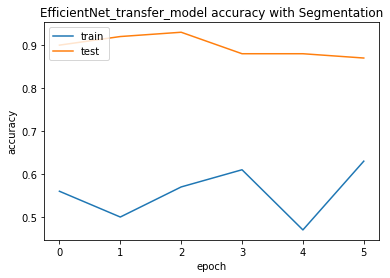

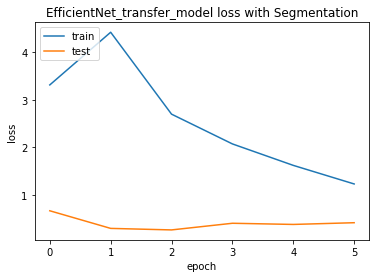

In [55]:
# summarize history for accuracy
plt.plot(fit_history.history['accuracy'])
plt.plot(fit_history.history['val_accuracy'])
plt.title('EfficientNet_transfer_model accuracy with Segmentation')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(fit_history.history['loss'])
plt.plot(fit_history.history['val_loss'])
plt.title('EfficientNet_transfer_model loss with Segmentation')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()